# LSTM model - text embedding

In [1]:
# import packages

import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
from tensorflow import keras

import datetime
import matplotlib.pyplot as plt
import preprocessor as p

from utils.embed_utils import read_glove_vecs

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import re
import string

In [2]:
# load data

def load_data(train_or_test):
    if train_or_test not in ['train', 'test']:
        return None
    path = 'data\CombinedTWTAQ_' + train_or_test + '.pkl'
    with open(path, 'rb') as infile:
        df = pickle.load(infile)
    return df

def clean_text(text):
    '''
    lowercase, remove puncs, remove urls
    '''
    text = p.clean(text)
    text = text.lower()
    #text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r"http\S+", ' ', text)
    return text
    
clean = lambda x: clean_text(x)

def df_to_xy(df):
    x = df.text.apply(clean)
    y = df.PP.apply(lambda xx: xx[75])
    #y = y.values
    return (x,y)

def sentences_to_indices_V2(X, word_to_index, max_len, padding='pre'):
    
    m = X.shape[0]
    X_ind = [[word_to_index[w] for w in text.lower().split() if w in word_to_index.keys()] for text in X]
    X_ind = keras.preprocessing.sequence.pad_sequences(X_ind, maxlen=max_len, padding=padding)
    return X_ind

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len,emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        if word_to_vec_map[word].shape[0] == emb_dim:
            emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it non-trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = keras.layers.Embedding(input_dim=vocab_len, output_dim=emb_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [3]:
x,y = df_to_xy(load_data('test'))
print(type(x.values))
print(type(y))

ind = 101
print(x[ind], y[ind])


<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
...big crooked hillary law firm, represented by her lawyer michael sussmann (do you believe this?) who worked baker hard &amp; gave him oppo research for “a russia probe.” this meeting, now eed, is the subject of senate inquiries and much more. an unconstitutional hoax. 0.06254236751011


## Load embedding

In [4]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('utils/glove.twitter.27B.50d.txt')

## Load data

In [5]:
max_len = 140
EMB_DIM = 50

df_train = load_data('train')
x, y = df_to_xy(df_train)

x_train, x_dev, y_train, y_dev = train_test_split(x,y, test_size=200, random_state=50)

m_train = x_train.shape[0]
m_dev = x_dev.shape[0]

x_train_org = x_train
x_train = sentences_to_indices_V2(x_train, word_to_index, max_len, padding='pre')
    
x_dev_org = x_dev
x_dev = sentences_to_indices_V2(x_dev, word_to_index, max_len, padding='pre')

print(x_train.shape)
print(y_train.shape)

y_train_org = y_train
y_train = np.nan_to_num(y_train)

(1145, 140)
(1145,)


## Model

In [6]:
def create_LSTM_model(input_shape, word_to_vec_map, word_to_index):
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = keras.layers.Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    X = keras.layers.LSTM(4, return_sequences=True, name='LSTM1')(embeddings)
    X = keras.layers.Dropout(0.25,name='Dropout1')(X)
    X = keras.layers.LSTM(4, return_sequences=False, name='LSTM2')(X)
    X = keras.layers.Dropout(0.25,name='Dropout2')(X)
    X = keras.layers.Dense(4,name='Dense',activation='sigmoid')(X)
    X = keras.layers.Dropout(0.1)(X)
    X = keras.layers.Dense(1,activation='linear')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = keras.models.Model(inputs=sentence_indices, outputs=X)
    
    return model

#max_len = 140
input_shape = (max_len,)

tf.reset_default_graph()

model = create_LSTM_model(input_shape, word_to_vec_map, word_to_index)

model.summary()

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

model.fit(x_train, y_train, epochs=50)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 140)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 140, 50)           59675750  
_________________________________________________________________
LSTM1 (LSTM)                 (None, 140, 4)            880       
_________________________________________________________________
Dropout1 (Dropout)           (None, 140, 4)            0         
_________________________________________________________________
LSTM2 (LSTM)                 (None, 4)                 144       
____________________________________________________________

## Evaluate accuracy

In [8]:
dev_loss, dev_acc = model.evaluate(x_dev,  y_dev, verbose=2)


print( np.sqrt( mean_squared_error(y_train, model.predict(x_train)) ) )
print( np.sqrt( mean_squared_error(y_dev, model.predict(x_dev)) ) )

print( np.sqrt( mean_squared_error(y_dev, 0*y_dev ) ) )

200/200 - 0s - loss: 0.0232 - mean_absolute_error: 0.0983
0.1494902392265442
0.15215962453934345
0.15246748337145208


## Conclusion


Guess 0:
- Train error: 15.13
- Dev error: 15.25
- Test error: 15.26

LSTM model with twitter embedding:
- Train error: 14.95
- Dev error: 15.21
- Test error: 15.40


In [10]:
# save model
savepath = 'MODEL_twtext_embed_nn.h5'
model.save(savepath)

In [5]:
#from keras.models import load_model
savepath = 'MODEL_twtext_embed_nn.h5'
model_load = keras.models.load_model(savepath)
model_load.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 140)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 140, 50)           59675750  
________

In [8]:
max_len = 140
#EMB_DIM = 50

df_test = load_data('test')
x_test, y_test = df_to_xy(df_test)

x_test =  sentences_to_indices_V2(x_test, word_to_index, max_len, padding='pre')
y_test_hat = model_load.predict(x_test)

print( np.sqrt( mean_squared_error(y_test, y_test_hat) ) )

0.15404710087104162


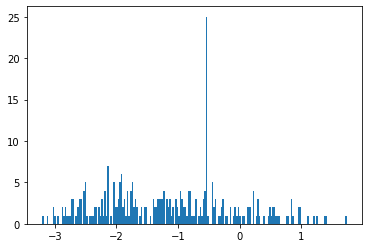

In [9]:
plt.figure()
plt.hist(100*y_test_hat,201)
plt.show()

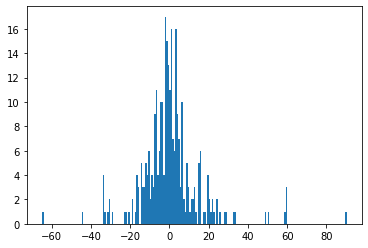

In [10]:
plt.figure()
plt.hist(100*y_test,201)
plt.show()